In [37]:
#기본 라이브러리 만들기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import warnings
warnings.filterwarnings('ignore')

# Decision Tree : 신용카드 연체 예측

### 데이터 임포트

In [68]:
#Personal Loan.csv 파일 불러오기
loan = pd.read_csv('/content/drive/MyDrive/DSL/2023-1 과제/[0202][HW]_DecisionTree_and_Ensemble/DecisionTree&Ensemble/Personal Loan.csv')
loan.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [69]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  2500 non-null   int64  
 1   Age                 2500 non-null   int64  
 2   Experience          2500 non-null   int64  
 3   Income              2500 non-null   int64  
 4   ZIP Code            2500 non-null   int64  
 5   Family              2500 non-null   int64  
 6   CCAvg               2500 non-null   float64
 7   Education           2500 non-null   int64  
 8   Mortgage            2500 non-null   int64  
 9   Personal Loan       2500 non-null   int64  
 10  Securities Account  2500 non-null   int64  
 11  CD Account          2500 non-null   int64  
 12  Online              2500 non-null   int64  
 13  CreditCard          2500 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 273.6 KB


여기서 ZIP Code, ID 열은 분석의 편의를 위해 빼도록 하겠다.

또 데이터들을 각각 raw_X, raw_y에 담아주도록 하자.

In [70]:
raw_X = loan.dropna().drop(['Personal Loan', 'ZIP Code', 'ID'], axis=1)
raw_X.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,1,0,0,0
1,45,19,34,3,1.5,1,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,1


In [71]:
raw_y = loan['Personal Loan']
raw_y.value_counts() # 이진분류(0,1) 문제

0    2244
1     256
Name: Personal Loan, dtype: int64

In [72]:
raw_y.value_counts(normalize = True)

0    0.8976
1    0.1024
Name: Personal Loan, dtype: float64

### 범주형 데이터 전처리 (원-핫 인코딩)

Education 열의 경우, 숫자로 되어있지만 범주형 데이터이다. <br>
원-핫 인코딩을 이용해 전처리를 해보도록 하자.

In [73]:
# 연속형이 아니라 범주형인 'Education'열을 One-hot Encoding으로 전처리
raw_X_one_hot = pd.get_dummies(data=raw_X, columns=['Education'], prefix='Education')
raw_X_one_hot.head()

,Age,Experience,Income,Family,CCAvg,Mortgage,Securities Account,CD Account,Online,CreditCard,Education_1,Education_2,Education_3
0,25,1,49,4,1.6,0,1,0,0,0,1,0,0
1,45,19,34,3,1.5,0,1,0,0,0,1,0,0
2,39,15,11,1,1.0,0,0,0,0,0,1,0,0
3,35,9,100,1,2.7,0,0,0,0,0,0,1,0
4,35,8,45,4,1.0,0,0,0,0,1,0,1,0


### 훈련 세트와 테스트 세트 분리

In [74]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(raw_X_one_hot, raw_y, train_size=0.7, test_size=0.3, random_state=1, stratify=raw_y)
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(1750, 13) (750, 13) (1750,) (750,)


In [75]:
raw_y.value_counts() 
# 0의 비율: 0.8976
# 1의 비율: 0.1024

0    2244
1     256
Name: Personal Loan, dtype: int64

In [76]:
test_y.value_counts()
# 0의 비율: 0.8973
# 1의 비율: 0.1027

0    673
1     77
Name: Personal Loan, dtype: int64

In [77]:
train_y.value_counts()
# 0의 비율: 0.8977
# 1의 비율: 0.1023

0    1571
1     179
Name: Personal Loan, dtype: int64

### 최적의 하이퍼 파라미터 찾기 : 그리드 서치

Gridsearch: 관심 있는 매개변수들을 대상으로 가능한 모든 조합을 시도하여 최적의 매개변수를 찾는 방법. <br> 즉, 우리에게 필요한 최적의 하이퍼 파라미터를 찾아준다 <br>
ex) max_depth를 몇으로 설정하는게 좋은지 등등 <br>

GridSearch는 확인하고 싶은 다양한 파라미터값을 넣어주면,
그것들을 하나씩 확인하면서 스코어를 내고, <br>
가장 좋은 성능의 모델에 대한 결과를 확인하고 사용할 수 있음

model_selection 모듈의 GridSearchCV 함수는 GridSearch + Cross validation의 약어로, <br>
k개의 폴드에 대해 최적의 하이퍼 파라미터를 모두 종합적으로 고려하여 최적의 파라미터를 출력한다. <br> 이때, 테스트하고자 하는 파라미터 값들을 사전(dictionary) 타입으로 정의해주어야 한다.

max_depth, min_samples_split에 대한 hyperparameter tuning을 실습해보자.

In [78]:
from sklearn.tree import DecisionTreeClassifier

loan_tree = DecisionTreeClassifier()
loan_tree.fit(train_X, train_y)

from sklearn.model_selection import GridSearchCV # 관심 있는 매개변수들을 대상으로 가능한 모든 조합을 시도하여 최적의 매개변수를 찾는 방법

# 테스트하고자 하는 파라미터 값들을 사전타입으로 정의
# max_depth 와 min_samples_split라는 parameter에 대해 범위 지정
hyperparamters = {'max_depth': list(range(2, 8)),  'min_samples_split': list(range(2, 20))}

# GridSearch 진행
GridCV = GridSearchCV(estimator=loan_tree, param_grid=hyperparamters, cv=5)
GridCV.fit(train_X, train_y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14, 15, 16, 17, 18,
                                               19]})

In [79]:
print(GridCV.best_params_) # 가장 좋은 성능을 보였을 때의 parameter
print(GridCV.best_score_) #위 파라미터로 했을 때 성능(평균 정확도)

{'max_depth': 5, 'min_samples_split': 2}
0.9834285714285713


In [80]:
GridCV.best_score_ #위 파라미터로 했을 때 성능(평균 정확도)

0.9834285714285713

In [81]:
#위 파라미터 값들로 모델을 훈련시켜보자!
loan_tree = DecisionTreeClassifier(max_depth=5, min_samples_split=9, random_state=0).fit(train_X, train_y)

In [82]:
#원래의 트리 성능
from sklearn.metrics import accuracy_score, f1_score

print("Decision Tree Accuracy for test data : {:.3f}".format(accuracy_score(test_y, loan_tree.predict(test_X))))
print("Decision Tree F1 score for test data : {:.3f}".format(f1_score(test_y, loan_tree.predict(test_X))))

Decision Tree Accuracy for test data : 0.979
Decision Tree F1 score for test data : 0.893


### 시각화

In [83]:
#export_graphviz 함수: graphviz 패키지를 불러와 시각화하기 위한 파일을 만든다
from sklearn.tree import export_graphviz

#export_graphviz()의 호출 결과로 out_file로 파일을 생성함
export_graphviz(loan_tree, #모델의 이름
                out_file = "loan_tree.dot",
                feature_names = train_X.columns,
                impurity = True, # impurity = True: 분순도를 표기 (True가 디폴트)
                filled = True) # filled = True: 색깔을 추가 (False가 디폴트) 

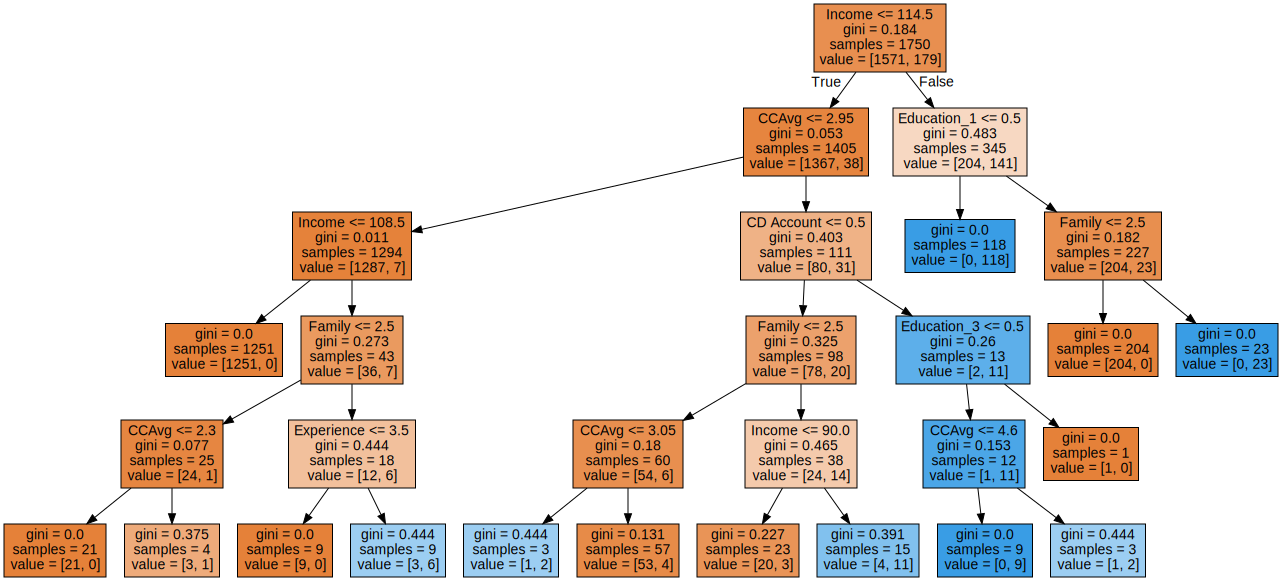

In [84]:
# 결정트리를 위한 시각화 패키지
import graphviz

#loan_tree 파일 열기 / 읽기
with open("loan_tree.dot") as f:
  dot_graph = f.read()

#시각화
graphviz.Source(dot_graph)

GridSearchCV로 최적의 하이퍼 파라미터를 찾았다. 성능이 보다 좋아진 것을 확인할 수 있다

# Voting Classifier

### 훈련 세트와 테스트 세트 분리

In [86]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(raw_X_one_hot, raw_y,
                                                    test_size = 0.2, random_state = 1)

### Voting Classifier 모델 만들기

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

#개별 모델은 로지스틱 회귀와 Decision Tree
model1 = LogisticRegression()
model2 = DecisionTreeClassifier()

In [88]:
#VotingClassifier
from sklearn.ensemble import VotingClassifier
voting = VotingClassifier(estimators = [('LR', model1), ('DT', model2)], voting = 'soft')

In [89]:
#VotingClassifier 학습/예측/평가
voting.fit(train_X, train_y)

VotingClassifier(estimators=[('LR', LogisticRegression()),
                             ('DT', DecisionTreeClassifier())],
                 voting='soft')

In [90]:
from sklearn.metrics import accuracy_score, f1_score
print("Voting Classifier Accuracy for test data : {:.4f}".format(accuracy_score(test_y, voting.predict(test_X))))

Voting Classifier Accuracy for test data : 0.9860


In [91]:
#개별 모델의 학습 / 예측 평가
classifiers = [model1, model2]
for i in classifiers:
  i.fit(train_X, train_y)
  pred = i.predict(test_X)
  class_name = i.__class__.__name__
  print('{0} accuracy: {1: .4f}'.format(class_name, accuracy_score(test_y, pred)))

LogisticRegression accuracy:  0.9580
DecisionTreeClassifier accuracy:  0.9860


#Random Forest

In [92]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(train_X, train_y)
pred = rf.predict(test_X)
print("Random Forest Classifier Accuracy for test data : {:.4f}".format(accuracy_score(test_y, pred)))

Random Forest Classifier Accuracy for test data : 0.9940


### 그리드 서치

In [93]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth': [5, 10, 15, 20]}

rf = RandomForestClassifier(n_estimators = 100)
GridCV = GridSearchCV(rf, param_grid = params, cv = 5, n_jobs = -1)
GridCV.fit(train_X, train_y)

print("최적의 파라미터: ", GridCV.best_params_)

rf = RandomForestClassifier(max_depth = 20, n_estimators = 100)
rf.fit(train_X, train_y)
pred = rf.predict(test_X)
print("Random Forest Classifier Accuracy for test data : {:.4f}".format(accuracy_score(test_y, pred)))
print("Random Forest Classifier F1 score for test data : {:.4f}".format(f1_score(test_y, pred)))

최적의 파라미터:  {'max_depth': 20}
Random Forest Classifier Accuracy for test data : 0.9920
Random Forest Classifier F1 score for test data : 0.9592


#Gradient Boost

In [94]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier()
gb_clf.fit(train_X, train_y)
gb_pred = gb_clf.predict(test_X)

print("Random Forest Classifier Accuracy for test data : {:.4f}".format(accuracy_score(test_y, gb_pred)))
print("Random Forest Classifier F1 score for test data : {:.4f}".format(f1_score(test_y, gb_pred)))

Random Forest Classifier Accuracy for test data : 0.9900
Random Forest Classifier F1 score for test data : 0.9495
